In [1]:
%matplotlib inline
import numpy as np
import torch
import random
import datetime
import tensorboardX
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch.distributions as tchd 
from torch import nn
from copy import deepcopy
from collections import defaultdict
from collections import OrderedDict as odict
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Theory

To be completed

In [2]:
device_name = 'cuda:0'
tch_device = torch.device(device_name)
tch_dtype = torch.double
torch.pi = torch.tensor(np.pi).to(device=tch_device, dtype=tch_dtype)

def isscalar(v):
    if torch.is_tensor(v):
        return v.numel() == 1
    else:
        return np.isscalar(v)
    
pgms_cntr = 0
def print_gpumem_stat():
    global pgms_cntr
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0) / 1.0e9
    a = torch.cuda.memory_allocated(0) / 1.0e9
    f = r - a  # free inside reserved
    print(f'Checkpoint {pgms_cntr}: Free: {f:.1f} GB, Allocated: {a:.1f} GB')
    pgms_cntr += 1

## Finding the Exact Smolluchowski Sum

In [3]:
class SMSum:
    def __init__(self, d, n_gpd, x_high, get_kernel):
        """
        Defines the exact Smolluchowski summation over a fixed grid

        Parameters
        ----------
        d: (int) the dimensionality of the points
        
        n_gpd: (int) the number of grid points in each dim
        
        x_high: (torch.tensor) the high boundary in each dim
        
        get_kernel: (callable) a function that takes two tensors 
                with shape (n, d) and returns a (d,) tensor.
        
        """
        
        # n_g -> The total number of points in the d-dim grid
        n_g = n_gpd ** d
        
        x_int_pd = torch.arange(1, n_gpd+1, device=tch_device, dtype=torch.int64)
        x_int = torch.cat([x_int_pd.repeat_interleave(n_gpd**(d-i-1), dim=0).repeat(
            (n_gpd**i,)).reshape(n_g, 1) for i in range(d)], dim=1)
        assert x_int.shape == (n_g, d)

        x_high = x_high
        assert x_high.shape == (d,)
        assert x_high.device == tch_device
        assert x_high.dtype == tch_dtype

        x_flt = x_int * (x_high / n_gpd)
        assert x_flt.shape == (n_g, d)
        
        x_flt_area = x_flt.prod(dim=-1)
        assert x_flt_area.shape == (n_g,)
        
        # integration element volume size dx = dx1 * dx2 * ... * dxd
        assert x_high.shape == (d,)
        dx_vol = torch.prod(x_high / n_gpd).item()
        x_high_area = torch.prod(x_high).item()
        
        # Meshed vectors of x_flt
        x_fmsh1 = x_flt.repeat_interleave(n_g, dim=0).reshape(n_g*n_g, d)
        assert x_fmsh1.shape == (n_g*n_g, d)
        x_fmsh2 = x_flt.repeat((n_g,1)).reshape(n_g*n_g, d)
        assert x_fmsh2.shape == (n_g*n_g, d)

        # Getting the kernel in flat and square forms
        K_1d = get_kernel(x_fmsh1, x_fmsh2)
        assert K_1d.shape == (n_g*n_g, )
        K_2d = K_1d.reshape(n_g, n_g)
        assert K_2d.shape == (n_g, n_g)

        # One time calculations
        delta_int = x_int.reshape(n_g, 1, d) - x_int.reshape(1, n_g, d)
        assert delta_int.shape == (n_g, n_g, d)

        ispos = (delta_int > 0).all(dim=-1)
        assert ispos.shape == (n_g, n_g)

        M_nz_idx1d = torch.nonzero(ispos.reshape(-1)).reshape(-1)
        assert M_nz_idx1d.ndim == 1

        iii = n_gpd ** torch.arange(d-1, -1, -1, device=tch_device, dtype=torch.int64).reshape(1, d)
        K_nz_rowid1d = ((delta_int[ispos, :] - 1) * iii).sum(dim=-1)
        K_nz_idx1d = K_nz_rowid1d * n_g + (M_nz_idx1d % n_g)

        M_nz1d = K_1d[K_nz_idx1d]
        
        # needed for __call__
        self.n_g = n_g
        self.K_2d = K_2d
        self.M_nz_idx1d = M_nz_idx1d
        self.K_nz_rowid1d = K_nz_rowid1d
        self.M_nz_colid1d = M_nz_idx1d % n_g
        self.M_nz1d = M_nz1d
        self.dx_vol = dx_vol
        self.x_flt_area = x_flt_area
        self.x_high_area = x_high_area
        
        # only needed for tests
        self.x_flt = x_flt
        # self.x_int = x_int
        # self.x_fmsh1 = x_fmsh1
        # self.x_fmsh2 = x_fmsh2
        # self.d = d
        # self.n_gpd = n_gpd
        
        # Printing the memory usage
        self.print_mem_usage()
    
    def get_x(self):
        return self.x_flt
        
    def __call__(self, rho, summer='efficient'):
        n_g, K_2d, M_nz1d = self.n_g, self.K_2d, self.M_nz1d
        M_nz_idx1d = self.M_nz_idx1d
        K_nz_rowid1d = self.K_nz_rowid1d
        M_nz_colid1d = self.M_nz_colid1d
        dx_vol = self.dx_vol
        x_flt_area = self.x_flt_area
        x_high_area = self.x_high_area
        
        assert rho.shape == (n_g,)
        L_nz1d = rho[K_nz_rowid1d]
        Q_nz1d = rho[M_nz_colid1d]
        
        influx = self.get_influx(Q_nz1d, L_nz1d, M_nz1d, M_nz_idx1d, n_g, summer, do_sq=False)
        assert influx.shape == (n_g,)
        
        influxsq = self.get_influx(Q_nz1d, L_nz1d, M_nz1d, M_nz_idx1d, n_g, summer, do_sq=True)
        assert influxsq.shape == (n_g,)
        
        K2drho = (K_2d * rho.reshape(1, n_g))
        assert K2drho.shape == (n_g, n_g)
        
        outflux = K2drho.sum(dim=-1) * rho
        assert outflux.shape == (n_g,)
        
        outfluxsq = K2drho.square().sum(dim=-1) * rho.square()
        assert outfluxsq.shape == (n_g,)
        
        # Accounting for dx in the Riemannian integration sum
        influx = influx * dx_vol
        outflux = outflux * dx_vol
        influxsq = influxsq * x_flt_area * dx_vol
        outfluxsq = outfluxsq * x_high_area * dx_vol
        
        outdict = dict(influx=influx, outflux=outflux,
                       influxsq=influxsq, outfluxsq=outfluxsq)
        
        # Running the test suite
        # assert summer == 'complete'
        # self.test_displacements(rho, Q, L, M)
        # self.test_conservation(influx, outflux)
        # self.test_smforloop(rho, influx, outflux)
        
        return outdict
    
    def get_influx(self, Q_nz1d, L_nz1d, M_nz1d, M_nz_idx1d, n_g, summer, do_sq=False):
        if summer == 'efficient':
            U_nz1d = (Q_nz1d * L_nz1d * M_nz1d)
            if do_sq:
                U_nz1d = U_nz1d.square()
            U_cs1d = torch.cumsum(U_nz1d, dim=0)
            ii = M_nz_idx1d // n_g
            jj = (ii < torch.cat([ii[1:], torch.full_like(ii[:1], n_g)], dim=0))
            kk = torch.nonzero(jj).reshape(-1)
            ll = ii[jj]
            vv = U_cs1d[kk]
            ww = vv - torch.cat([torch.zeros_like(vv[:1]), vv[:-1]], dim=0)
            influx = torch.zeros(n_g, device=tch_device, dtype=tch_dtype)
            influx[ll] = ww / (4. if do_sq else 2.)
            assert influx.shape == (n_g,)
        elif summer == 'complete':
            M_1d = torch.zeros(n_g*n_g, device=tch_device, dtype=tch_dtype)
            M_1d[M_nz_idx1d] = M_nz1d
            M = M_1d.reshape(n_g, n_g)
            L_1d = torch.zeros(n_g*n_g, device=tch_device, dtype=tch_dtype)
            L_1d[M_nz_idx1d] = L_nz1d
            L = L_1d.reshape(n_g, n_g)
            Q = rho.reshape(1,n_g).expand((n_g, n_g))
            QLM = (Q * L * M)
            if do_sq:
                QLM = QLM.square()
            influx = QLM.sum(dim=-1) / (4. if do_sq else 2.)
            assert influx.shape == (n_g,)
        else:
            raise ValueError(f'{influx_summer} not implemented!')
        
        return influx
    
    def test_displacements(self, rho, Q, L, M):
        """
        Making sure that for all i, j we have:
            M[i, j] = K[i-j, j],
            L[i, j] = rho[i-j],
            Q[i, j] = rho[j].
        """
        x_int, n_g, n_gpd, d, K_2d = self.x_int, self.n_g, self.n_gpd, self.d, self.K_2d

        x_imsh1 = x_int.repeat_interleave(n_g, dim=0).reshape(n_g*n_g, d)
        assert x_imsh1.shape == (n_g*n_g, d)
        x_imsh2 = x_int.repeat((n_g,1)).reshape(n_g*n_g, d)
        assert x_imsh2.shape == (n_g*n_g, d)
        xint2i = lambda xint: np.sum((xint - 1) * (n_gpd**(d - 1 - np.arange(d))))
        for xi_int, xj_int in zip(x_imsh1.detach().cpu().numpy(), x_imsh2.detach().cpu().numpy()):
            """Example: xi_int, xj_int = np.array([2, 3]), np.array([1, 2])"""
            if not (xi_int > xj_int).all():
                continue
            xij_int = xi_int - xj_int
            i = xint2i(xi_int)
            j = xint2i(xj_int)
            ij = xint2i(xij_int)
            assert torch.allclose(K_2d[ij, j], M[i,j])
            assert torch.allclose(L[i,j], rho[ij])
            assert torch.allclose(Q[i,j], rho[j])
            
    def test_conservation(self, influx, outflux):
        """
        Testing if the influx and outflux mass is being conserved or not.
        """
        x_int, n_g, d = self.x_int, self.n_g, self.d
        
        assert x_int.shape == (n_g, d)
        mass_influx = (influx.reshape(n_g, 1)  * x_int).sum(dim=0)
        mass_outflux = (outflux.reshape(n_g, 1) * x_int).sum(dim=0)
        is_conserved = torch.allclose(mass_influx, mass_outflux)
        assert is_conserved, (f'Make sure the kernel does not allow ' + 
            f'coagulations beyond size {n_gpd} in each dimension')
    
    def test_smforloop(self, rho, influx, outflux):
        """
        Testing if the solving the SM equation with for loops yields the same results
        """
        x_int, n_gpd, d, K_2d = self.x_int, self.n_gpd, self.d, self.K_2d
        
        xint2i = lambda xint: np.sum((xint - 1) * (n_gpd**(d - 1 - np.arange(d))))
        influx_for = []
        outflux_for = []
        for i, pnt_i in enumerate(x_int):
            i_inflx = 0.0
            i_otflx = 0.0
            for j, pnt_j in enumerate(x_int):
                assert pnt_i.shape == (d,)
                assert pnt_j.shape == (d,)

                i_otflx += (K_2d[i,j] * rho[i] * rho[j]).item()

                pnt_ij = pnt_i - pnt_j
                ij = xint2i(pnt_ij.detach().cpu().numpy())
                if not (pnt_ij > 0).all():
                    continue

                aa = K_2d[ij, j]
                bb = rho[ij]
                cc = rho[j]

                i_inflx += (aa*bb*cc).item()/2.
            influx_for.append(i_inflx)
            outflux_for.append(i_otflx)
        influx_for = torch.from_numpy(np.array(influx_for)).to(dtype=tch_dtype, device=tch_device)
        outflux_for = torch.from_numpy(np.array(outflux_for)).to(dtype=tch_dtype, device=tch_device)

        assert torch.allclose(influx_for, influx)
        assert torch.allclose(outflux_for, outflux)
    
    def print_mem_usage(self):
        total = 0
        print('SMSolver GPU Memory Usage:')
        for key, val in self.__dict__.items():
            if torch.is_tensor(val):
                valmem = val.element_size() * val.nelement() / 1.0e9
                total += valmem
                print(f'  {key}:{" " * (21-len(key))}{valmem:.3f} GB')
        print('  ' + '='*30)
        print(f'  Total:{16 * " "}{total:.3f} GB')

class CustomKernel:
    def __init__(self, pnorm, maxnorm, scale, alpha, beta, gamma):
        self.scale = scale
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.pnorm = pnorm
        self.maxnorm = maxnorm
        
    def __call__(self, x1, x2):
        """
        Defines the kernel function between two points.

        Parameters
        ----------
        x1     : torch.tensor with shape (..., n, d)
        x2     : torch.tensor with shape (..., n, d)

        Returns
        -------
        kvec   : torch.tensor with shape (n,)
        """
        pnorm, maxnorm, scale = self.pnorm, self.maxnorm, self.scale
        alpha, beta, gamma = self.alpha, self.beta, self.gamma
        
        n_tup, d = x1.shape[:-1], x1.shape[-1]
        assert x1.shape == (*n_tup, d)
        assert x2.shape == (*n_tup, d)

        x12 = torch.cat([x1.unsqueeze(-1), x2.unsqueeze(-1)], dim=-1)
        assert x12.shape == (*n_tup, d, 2)

        x12norm_d = torch.norm(x12, p=pnorm, dim=-1)
        assert x12norm_d.shape == (*n_tup, d)

        x12norm = x12norm_d.sum(dim=-1)
        assert x12norm.shape == (*n_tup,)

        kvec = (x12norm.pow(alpha) + beta).abs().pow(gamma)
        assert kvec.shape == (*n_tup,)

        # Making sure no particles of size 1 or larger get created.
        kvec = kvec * (scale * (x12norm < maxnorm))
        assert kvec.shape == (*n_tup,)

        return kvec

class RhoGMM:
    def __init__(self, pi, mu, std, bias, scale):
        self.mix = tchd.Categorical(torch.tensor(pi, dtype=tch_dtype, device=tch_device))
        mu_tensor = torch.tensor(mu, dtype=tch_dtype, device=tch_device)
        std_tensor = torch.tensor(std, dtype=tch_dtype, device=tch_device)
        self.comp = tchd.Normal(mu_tensor, std_tensor)
        self.gmm = tchd.MixtureSameFamily(self.mix, self.comp)
        self.bias = bias
        self.scale = scale
    
    def __call__(self, x):
        """
        Defines the initial masses using a GMM model.

        Parameters
        ----------
        x     : torch.tensor with shape (..., n, 1)

        Returns
        -------
        rho   : torch.tensor with shape (..., n)
        """
        assert x.shape[-1] == 1, 'higher dim not implemented yet'
        n_tup, d = x.shape[:-1], x.shape[-1]
        nrows = int(np.prod(n_tup))
        x_rshp = x.reshape(nrows, d)
        rho = self.bias + self.gmm.log_prob(x_rshp).exp().reshape(*n_tup) * self.scale
        return rho

class RhoLin:
    def __init__(self, rho1, rho2, x_high):
        self.rho1 = rho1
        self.slope = ((rho2 - rho1) / d) * x_high
     
    def __call__(self, x):
        """
        Defines the initial masses using a negative-slope model.

        Parameters
        ----------
        x     : torch.tensor with shape (..., n, d)

        Returns
        -------
        rho   : torch.tensor with shape (..., n)
        """
        n_tup, d = x.shape[:-1], x.shape[-1]
        assert self.slope.shape == (d,)
        
        slope_expanded = self.slope.reshape(*([1]*len(n_tup)), d).expand(*n_tup, d)
        rho = self.rho1 + (slope_expanded * x).sum(dim=-1)
        return rho

### Some Tested Settings

### Running Smolluchowski Simulation 

In [4]:
"""
This setting has a moderate "variance to squared-mean" ratio for the time derivative:
   E_{xi}[Var_{xj}(d\rho/dt)] = 3.15
   E_{xi}[  E_{xj}[d\rho/dt]] = 1.05
   R = 3.15 / 1.05 = 3.01
"""

d = 2
n_gpd = 100
x_high = torch.tensor([1.0]*d, dtype=tch_dtype, device=tch_device)
get_kernel = CustomKernel(pnorm=0.5, maxnorm=1.14, scale=1.23, 
                          alpha=1.5, beta=0.0, gamma=1.0)
get_rhoinit = RhoLin(rho1=3.0, rho2=2.0, x_high=x_high)
t_high = 1.0
dt_g = t_high / 100.0
ker_name, rhoi_name = 'harmonic_A', 'lin_A'

In [5]:
n_g = n_gpd ** d
print_gpumem_stat()
smsolver = SMSum(d, n_gpd, x_high, get_kernel)
print_gpumem_stat()
x_grid1d = smsolver.get_x()
rho_init = get_rhoinit(x_grid1d)
assert rho_init.shape == (n_g,)

n_t = int(t_high / dt_g)
t_g = dt_g * torch.arange(n_t, dtype=tch_dtype, device=tch_device)
rho_g = torch.zeros(n_t, n_g, dtype=tch_dtype, device=tch_device)
drhodt_g = torch.zeros(n_t, n_g, dtype=tch_dtype, device=tch_device)
drhodt_var_g = torch.zeros(n_t, n_g, dtype=tch_dtype, device=tch_device)
rho_g[0, :] = rho_t = rho_init
for t in range(1, n_t):
    soldict = smsolver(rho_t, summer='efficient')
    influx = soldict['influx']
    outflux = soldict['outflux']
    influxsq = soldict['influxsq']
    outfluxsq = soldict['outfluxsq']
    drhodt_t = (influx - outflux)
    drhodt_var_t = (outfluxsq - outflux.square()) + (influxsq - influx.square())
    rho_g[t, :] = rho_t = rho_t + drhodt_t * dt_g
    drhodt_g[t-1, :] = drhodt_t
    drhodt_var_g[t-1, :] = drhodt_var_t
drhodt_g[-1, :] = drhodt_t
drhodt_var_g[-1, :] = drhodt_var_t

if d != 1:
    del smsolver
print_gpumem_stat()

rho_g_np = rho_g.detach().cpu().numpy()
rho_gpdf_np = rho_g_np / rho_g_np.sum(axis=1, keepdims=True)
drhodt_g_np = drhodt_g.detach().cpu().numpy()
drhodt_var_g_np = drhodt_var_g.detach().cpu().numpy()
drhodt_g_sq_np = drhodt_g.square().detach().cpu().numpy()

aa, bb = drhodt_g_sq_np.mean(), drhodt_var_g_np.mean()
print('*'*50)
print(f'Mean Squared Time Derivative  = {aa:.4f}')
print(f'Mean Time Derivative Variance = {bb:.4f}')
print(f'Mean-to-Mean Ratio.           = {bb/aa:.4f}')

Checkpoint 0: Free: 0.0 GB, Allocated: 0.0 GB
SMSolver GPU Memory Usage:
  K_2d:                 0.800 GB
  M_nz_idx1d:           0.196 GB
  K_nz_rowid1d:         0.196 GB
  M_nz_colid1d:         0.196 GB
  M_nz1d:               0.196 GB
  x_flt_area:           0.000 GB
  x_flt:                0.000 GB
  Total:                1.584 GB
Checkpoint 1: Free: 9.6 GB, Allocated: 1.6 GB
Checkpoint 2: Free: 11.2 GB, Allocated: 0.0 GB
**************************************************
Mean Squared Time Derivative  = 0.0271
Mean Time Derivative Variance = 0.3610
Mean-to-Mean Ratio.           = 13.3350


In [6]:
########################################
################ Plotting ##############
########################################
if d == 1:
    x_plt = x_grid1d.detach().cpu().numpy().ravel()
    y_plt = t_g.detach().cpu().numpy() * 1.01
    c_plt1 = rho_gpdf_np
    c_plt2 = rho_g_np
    c_plt3 = smsolver.K_2d.detach().cpu().numpy()
    c_plt4 = drhodt_g_sq_np
    c_plt5 = drhodt_var_g_np

    n_rows, n_cols = 2, 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*2.5), 
                             dpi=72, sharex=True, sharey=False)

    def plot_rho_vs_xt(x_plt, y_plt, c_plt, fig, ax, add_cb=True):
        im = ax.pcolor(x_plt, y_plt, c_plt, linewidth=0, cmap='RdBu_r',
                       rasterized=True, shading='auto')
        if add_cb:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax)
        return fig, ax

    ax = axes[0, 0]
    plot_rho_vs_xt(x_plt, y_plt, c_plt1, fig, ax, add_cb=False)
    ax.set_title('Particle Density')
    ax.set_xlabel('Particle Size')
    ax.set_ylabel('Time')

    ax = axes[0, 1]
    plot_rho_vs_xt(x_plt, y_plt, c_plt2, fig, ax)
    ax.set_title('Particle Counts')
    ax.set_xlabel('Particle Size');
    ax.set_ylabel('Time')

    ax = axes[1, 0]
    plot_rho_vs_xt(x_plt-0.01, x_plt-0.01, c_plt3, fig, ax)
    ax.set_title('Kernel')
    ax.set_xlabel('Particle Size');
    ax.set_ylabel('Particle Size');

    ax = axes[1, 1]
    plot_rho_vs_xt(x_plt, y_plt, c_plt4, fig, ax)
    ax.set_title(f'Sq. Time Der.\n(M={c_plt4.mean():.2f})')
    ax.set_xlabel('Particle Size');
    ax.set_ylabel('Time');

    ax = axes[1, 2]
    plot_rho_vs_xt(x_plt, y_plt, c_plt5, fig, ax)
    ax.set_title(f'Time Der. Var.\n(M={c_plt5.mean():.2f}, R={c_plt5.mean() / c_plt4.mean():.2f})')
    ax.set_xlabel('Particle Size');
    ax.set_ylabel('Time');

    ax = axes[0, 2]
    plot_rho_vs_xt(x_plt, y_plt, np.log10(1e-2 + c_plt5) - np.log10(1e-2 + c_plt4), fig, ax)
    ax.set_title(f'Log-10 Ratio')
    ax.set_xlabel('Particle Size');
    ax.set_ylabel('Time');

    fig.set_tight_layout(True)

### Utitlity functions

In [7]:
class BatchRNG:
    is_batch = True

    def __init__(self, shape, lib, device, dtype, 
                 unif_cache_cols=1_000_000, 
                 norm_cache_cols=5_000_000):
        assert lib in ('torch', 'numpy')
        
        self.lib = lib
        self.device = device

        self.shape = shape
        self.shape_prod = int(np.prod(self.shape))
        self.shape_len = len(self.shape)
        self.reset_shape_attrs(shape)
        
        if self.lib == 'torch':
            self.rngs = [torch.Generator(device=self.device) for _ in range(self.shape_prod)]
        else:
            self.rngs = [None for _ in range(self.shape_prod)]
        self.dtype = dtype

        self.unif_cache_cols = unif_cache_cols
        if self.lib == 'torch':
            self.unif_cache = torch.empty((self.shape_prod, self.unif_cache_cols),
                                          device=self.device, dtype=dtype)
        else:
            self.unif_cache = np.empty((self.shape_prod, self.unif_cache_cols), dtype=dtype)
        self.unif_cache_col_idx = self.unif_cache_cols  # So that it would get refilled immediately
        self.unif_cache_rng_states = None

        self.norm_cache_cols = norm_cache_cols
        if self.lib == 'torch':
            self.norm_cache = torch.empty((self.shape_prod, self.norm_cache_cols),
                                          device=self.device, dtype=dtype)
        else:
            self.norm_cache = np.empty((self.shape_prod, self.norm_cache_cols), dtype=dtype)
        self.norm_cache_col_idx = self.norm_cache_cols  # So that it would get refilled immediately
        self.norm_cache_rng_states = None
        
        self.np_qr = np.linalg.qr
        try:
            ver = tuple(int(x) for x in np.__version__.split('.'))
            np_majorver, np_minorver, np_patchver, *_ = ver
            if not((np_majorver >= 1) and (np_minorver >= 22)):
                def np_qr_fakebatch(a):
                    b = a.reshape(-1, a.shape[-2], a.shape[-1])
                    q, r = list(zip(*[np.linalg.qr(x) for x in b]))
                    qs = np.stack(q, axis=0)
                    rs = np.stack(r, axis=0)
                    qout = qs.reshape(*a.shape[:-2], qs.shape[-2], qs.shape[-1])
                    rout = rs.reshape(*a.shape[:-2], rs.shape[-2], rs.shape[-1])
                    return qout, rout
                self.np_qr = np_qr_fakebatch
        except Exception:
            pass

    def reset_shape_attrs(self, shape):
        self.shape = shape
        self.shape_prod = int(np.prod(self.shape))
        self.shape_len = len(self.shape)

    def seed(self, seed_arr):
        # Collecting the rng_states after seeding
        assert isinstance(seed_arr, np.ndarray)
        assert len(self.rngs) == seed_arr.size
        flat_seed_arr = seed_arr.copy().reshape(-1)
        if self.lib == 'torch':
            np_random = np.random.RandomState(seed=0)
            for seed, rng in zip(flat_seed_arr, self.rngs):
                np_random.seed(seed)
                balanced_32bit_seed = np_random.randint(0, 2**31-1, dtype=np.int32)
                rng.manual_seed(int(balanced_32bit_seed))
        else:
            self.rngs = [np.random.RandomState(seed=seed) for seed in flat_seed_arr]            

        if self.unif_cache_col_idx < self.unif_cache_cols:
            self.refill_unif_cache()
            # The cache has been used before, so in order to be able to
            # concat this sampler with the non-reseeded sampler, we should not
            # change the self.unif_cache_cols.

            # Note: We should not refill the uniform cache if the model
            # has not been initialized. This is done to keep the backward
            # compatibility and reproducibility properties with the old scripts.
            # Otherwise, the order of random samplings will change. Remember that
            # the old script first uses dirichlet and priors, and then refills
            # the unif/norm cache. In order to be similar, we should avoid
            # refilling the cache upon the first .seed() call
        if self.norm_cache_col_idx < self.norm_cache_cols:
            self.refill_norm_cache()

    def get_state(self):
        state_dict = dict(unif_cache_rng_states=self.unif_cache_rng_states,
                          norm_cache_rng_states=self.norm_cache_rng_states,
                          norm_cache_col_idx=self.norm_cache_col_idx,
                          unif_cache_col_idx=self.unif_cache_col_idx,
                          rng_states=self.get_rng_states(self.rngs))
        return state_dict

    def set_state(self, state_dict):
        unif_cache_rng_states = state_dict['unif_cache_rng_states']
        norm_cache_rng_states = state_dict['norm_cache_rng_states']
        norm_cache_col_idx = state_dict['norm_cache_col_idx']
        unif_cache_col_idx = state_dict['unif_cache_col_idx']
        rng_states = state_dict['rng_states']

        if unif_cache_rng_states is not None:
            self.set_rng_states(unif_cache_rng_states, self.rngs)
            self.refill_unif_cache()
            self.unif_cache_col_idx = unif_cache_col_idx
        else:
            self.unif_cache_col_idx = self.unif_cache_cols
            self.unif_cache_rng_states = None

        if norm_cache_rng_states is not None:
            self.set_rng_states(norm_cache_rng_states, self.rngs)
            self.refill_norm_cache()
            self.norm_cache_col_idx = norm_cache_col_idx
        else:
            self.norm_cache_col_idx = self.norm_cache_cols
            self.norm_cache_rng_states = None

        self.set_rng_states(rng_states, self.rngs)

    def get_rngs(self):
        return self.rngs

    def set_rngs(self, rngs, shape):
        assert isinstance(rngs, list)
        self.reset_shape_attrs(shape)
        self.rngs = rngs
        assert len(self.rngs) == self.shape_prod, f'{len(self.rngs)} != {self.shape_prod}'

    def get_rng_states(self, rngs):
        """
        getting state in ByteTensor
        """
        rng_states = []
        for i, rng in enumerate(rngs):
            rng_state = rng.get_state()
            if self.lib == 'torch':
                rng_state = rng_state.detach().clone()
            rng_states.append(rng_state)
        return rng_states

    def set_rng_states(self, rng_states, rngs):
        """
        rng_states should be ByteTensor (RNG state must be a torch.ByteTensor)
        """
        assert isinstance(rng_states, list), f'{type(rng_states)}, {rng_states}'
        for i, rng in enumerate(rngs):
            rs = rng_states[i]
            if self.lib == 'torch':
                rs = rs.cpu()
            rng.set_state(rs)

    def __call__(self, gen, sample_shape):
        assert self.lib == 'torch'
        sample_shape_rightmost = sample_shape[self.shape_len:]
        random_vars = []
        for i, rng in enumerate(self.rngs):
            rng_state = rng.get_state()
            rng_state = rng_state.detach().clone()
            torch.cuda.set_rng_state(rng_state, self.device)
            random_vars.append(gen.sample(sample_shape_rightmost))
            rng.set_state(torch.cuda.get_rng_state(self.device).detach().clone())
        rv = torch.stack(random_vars, dim=0).reshape(*sample_shape)
        return rv

    def dirichlet(self, gen_list, sample_shape):
        assert self.lib == 'torch'
        sample_shape_rightmost = sample_shape[self.shape_len:]
        random_vars = []
        for i, (gen_, rng) in enumerate(zip(gen_list, self.rngs)):
            rng_state = rng.get_state().detach().clone()
            torch.cuda.set_rng_state(rng_state, self.device)
            random_vars.append(gen_.sample(sample_shape_rightmost))
            rng.set_state(torch.cuda.get_rng_state(self.device).detach().clone())

        rv = torch.stack(random_vars, dim=0)
        rv = rv.reshape(*self.shape, *rv.shape[1:])
        return rv

    def refill_unif_cache(self):
        self.unif_cache_rng_states = self.get_rng_states(self.rngs)
        if self.lib == 'torch':
            for row, rng in enumerate(self.rngs):
                self.unif_cache[row].uniform_(generator=rng)
        else:
            for row, rng in enumerate(self.rngs):
                self.unif_cache[row] = rng.rand(self.unif_cache_cols)

    def refill_norm_cache(self):
        self.norm_cache_rng_states = self.get_rng_states(self.rngs)
        if self.lib == 'torch':
            for row, rng in enumerate(self.rngs):
                self.norm_cache[row].normal_(generator=rng)
        else:
            for row, rng in enumerate(self.rngs):
                self.norm_cache[row] = rng.randn(self.norm_cache_cols)

    def uniform(self, sample_shape):
        sample_shape_tuple = tuple(sample_shape)
        assert sample_shape_tuple[:self.shape_len] == self.shape

        sample_shape_rightmost = sample_shape[self.shape_len:]
        cols = np.prod(sample_shape_rightmost)
        if self.unif_cache_col_idx + cols >= self.unif_cache_cols:
            self.refill_unif_cache()
            self.unif_cache_col_idx = 0

        samples = self.unif_cache[:, self.unif_cache_col_idx: (self.unif_cache_col_idx + cols)]
        samples = samples.reshape(*sample_shape)
        self.unif_cache_col_idx += cols

        return samples

    def normal(self, sample_shape):
        sample_shape_tuple = tuple(sample_shape)
        cols = np.prod(sample_shape_tuple) // self.shape_prod
        assert cols * self.shape_prod == np.prod(sample_shape_tuple)
        if self.norm_cache_col_idx + cols >= self.norm_cache_cols:
            self.refill_norm_cache()
            self.norm_cache_col_idx = 0

        samples = self.norm_cache[:, self.norm_cache_col_idx: (self.norm_cache_col_idx + cols)]
        samples = samples.reshape(*sample_shape)
        self.norm_cache_col_idx += cols

        return samples
    
    def so_n(self, sample_shape):
        sample_shape_tuple = tuple(sample_shape)
        
        assert sample_shape_tuple[-2] == sample_shape_tuple[-1]
        n_bch, d = self.shape_prod, sample_shape_tuple[-1]
        sample_numel = np.prod(sample_shape_tuple)
        n_v = sample_numel // (self.shape_prod * d * d)
        assert sample_numel == (n_bch * n_v * d * d)
        qr_factorizer = torch.qr if self.lib == 'torch' else self.np_qr
        diagnalizer = torch.diagonal if self.lib == 'torch' else np.diagonal
        signer = torch.sign if self.lib == 'torch' else np.sign
        
        norms = self.normal((n_bch, n_v, d, d))
        assert norms.shape == (n_bch, n_v, d, d)
        q, r = qr_factorizer(norms)
        assert q.shape == (n_bch, n_v, d, d)
        assert r.shape == (n_bch, n_v, d, d)
        r_diag = diagnalizer(r, 0, -2, -1)
        assert r_diag.shape == (n_bch, n_v, d)
        r_diag_sign = signer(r_diag)
        assert r_diag_sign.shape == (n_bch, n_v, d)
        q_signed = q * r_diag_sign.reshape(n_bch, n_v, 1, d)
        assert q_signed.shape == (n_bch, n_v, d, d)
        so_n = q_signed.reshape(*sample_shape_tuple)
        assert so_n.shape == sample_shape_tuple

        return so_n

    @classmethod
    def Merge(cls, sampler1, sampler2):
        assert sampler1.shape_len == sampler2.shape_len == 1

        device = sampler1.device
        dtype = sampler1.dtype
        chain_size = (sampler1.shape[0]+sampler2.shape[0],)

        state_dict1, state_dict2 = sampler1.get_state(), sampler2.get_state()

        merged_state_dict = dict()
        for key in state_dict1:
            if key in ('unif_cache_rng_states', 'norm_cache_rng_states', 'rng_states'):
                # saba modified
                if (state_dict1[key] is None) and (state_dict2[key] is None):
                    merged_state_dict[key] = None
                elif (state_dict1[key] is None) or (state_dict2[key] is None):
                    raise ValueError(f"{key} with None occurance")
                else:
                    merged_state_dict[key] = state_dict1[key] + state_dict2[key]
            elif key in ('norm_cache_col_idx', 'unif_cache_col_idx'):
                assert state_dict1[key] == state_dict2[key]
                merged_state_dict[key] = state_dict1[key]
            else:
                raise ValueError(f'Unknown rule for {key}')

        sampler = cls(device, chain_size, dtype)
        sampler.set_state(merged_state_dict)
        return sampler

    @classmethod
    def Subset(cls, sampler, inds):
        assert sampler.shape_len == 1

        device = sampler.device
        dtype = sampler.dtype
        chain_size_sub = (len(inds),)

        state_dict = sampler.get_state()

        sub_state_dict = dict()
        for key in state_dict:
            if key in ('unif_cache_rng_states', 'norm_cache_rng_states',
                       'rng_states'):
                sub_state_dict[key] = [state_dict[key][ind] for ind in inds]
            elif key in ('norm_cache_col_idx', 'unif_cache_col_idx'):
                sub_state_dict[key] = state_dict[key]
            else:
                raise ValueError(f'Unknown rule for {key}')

        sampler = cls(device, chain_size_sub, dtype)
        sampler.set_state(sub_state_dict)
        return sampler

In [8]:
class Visualizer:
    def __init__(self, x_high, t_high, d, n_gpd_plt, n_seeds):
        if d != 1:
            return None

        fig, axes = plt.subplots(1, 2, figsize=(6., 2.5), sharex=True, sharey=True)
        caxes = [make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05) for ax in axes]

        n_g_plt = n_gpd_plt ** 2
        
        with torch.no_grad():
            x_plt1d = torch.linspace(0.0, x_high.item(), n_gpd_plt, 
                                     device=tch_device, dtype=tch_dtype)
            t_plt1d = torch.linspace(0.0, t_high, n_gpd_plt, 
                                     device=tch_device, dtype=tch_dtype)

            x_pltmsh = x_plt1d.reshape(1, n_gpd_plt).expand(n_gpd_plt, n_gpd_plt)
            t_pltmsh = t_plt1d.reshape(n_gpd_plt, 1).expand(n_gpd_plt, n_gpd_plt)

            x_pltmsh_1d = x_pltmsh.reshape(1, n_g_plt, 1).expand(n_seeds, n_g_plt, 1)
            t_pltmsh_1d = t_pltmsh.reshape(1, n_g_plt, 1).expand(n_seeds, n_g_plt, 1)

        x_plt1d_np = x_plt1d.detach().cpu().numpy()
        t_plt1d_np = t_plt1d.detach().cpu().numpy()
        
        self.x_pltmsh_1d = x_pltmsh_1d
        self.t_pltmsh_1d = t_pltmsh_1d
        self.n_g_plt = n_g_plt
        self.x_plt1d_np = x_plt1d_np
        self.t_plt1d_np = t_plt1d_np
        self.fig = fig
        self.axes = axes
        self.caxes = caxes
        self.n_seeds = n_seeds
        
    def __call__(self, model, dpi=72):
        if d != 1:
            return None, None
        x_pltmsh_1d = self.x_pltmsh_1d
        t_pltmsh_1d = self.t_pltmsh_1d
        n_g_plt = self.n_g_plt
        x_plt1d_np = self.x_plt1d_np
        t_plt1d_np = self.t_plt1d_np
        fig = self.fig
        axes = self.axes
        caxes = self.caxes
        
        rho_plt = model(x_pltmsh_1d, t_pltmsh_1d).mean(dim=0)
        assert rho_plt.shape == (n_g_plt,)
        
        rho_plt_np = rho_plt.detach().cpu().numpy().reshape(n_gpd_plt, n_gpd_plt)
        rhopdf_plt_np = rho_plt_np / rho_plt_np.sum(axis=1, keepdims=True)

        ax, cax = axes[0], caxes[0]
        im = ax.pcolor(x_plt1d_np, t_plt1d_np, rhopdf_plt_np, linewidth=0,
                       rasterized=True, shading='auto', cmap='RdBu_r')
        fig.colorbar(im, cax=cax)
        ax.set_title('Particle Density')
        ax.set_xlabel('Particle Size')
        ax.set_ylabel('Time')

        ax, cax = axes[1], caxes[1]
        im = ax.pcolor(x_plt1d_np, t_plt1d_np, rho_plt_np, linewidth=0,
                       rasterized=True, shading='auto', cmap='RdBu_r')
        fig.colorbar(im, cax=cax)
        ax.set_title('Particle Counts')
        ax.set_xlabel('Particle Size')

        fig.set_tight_layout(True)
        fig.set_dpi(dpi)
        
        return fig, axes

ema_gamma, ema_gamma_sq = 0.999, 0.998

def update_ema(loss, loss_ema, loss_ema_sq):
    """
    Updates the exponential moving average of a statistic (namely losss).
    
    Parameters
    ----------
    loss         : torch.tensor with shape (n_seeds,).
    
    loss_ema     : torch.tensor with shape (n_seeds,)
                   or None for the first iteration.
                   
    loss_ema_sq  : torch.tensor with shape (n_seeds,)
                   or None for the first iteration.

    Returns
    -------
    loss_ema     : torch.tensor  with shape (n_seeds,).
    
    loss_ema_sq  : torch.tensor  with shape (n_seeds,).
    
    loss_ema_std : numpy.ndarray with shape (n_seeds,).
    """
    loss_ema = loss if loss_ema is None else ema_gamma * loss_ema + (1-ema_gamma) * loss
    loss_ema_sq = (loss**2) if loss_ema_sq is None else ema_gamma_sq * loss_ema_sq + (1-ema_gamma_sq) * (loss**2)
    loss_popvar = (loss_ema_sq - (loss_ema**2)).detach().cpu().numpy()
    loss_popvar[loss_popvar < 0] = 0
    loss_ema_std = np.sqrt(loss_popvar) * np.sqrt((1-ema_gamma)/(1+ema_gamma))
    return loss_ema, loss_ema_sq, loss_ema_std

### Defining the Sampler

In [9]:
class XSampler:
    def __init__(self, batch_rng):
        self.batch_rng = batch_rng
    
    def np_exlinspace(self, start, end, n):
        assert n >= 1
        a = np.linspace(start, end, n, endpoint=False) 
        b = a + 0.5 * (end - a[-1])
        return b
    
    def tch_exlinspace(self, start, end, n):
        assert n >= 1
        a = torch.linspace(start, end, n+1, device=tch_device, dtype=tch_dtype)[:-1] 
        b = a + 0.5 * (end - a[-1])
        return b
    
    def __call__(self, xi, n_j, do_detspacing=True):
        n_i, d = xi.shape[-2:]
        mb_shape = xi.shape[:-2]
        n_bch = int(np.prod(mb_shape))
        
        xi = xi.reshape(n_bch, n_i, d)
        assert xi.shape == (n_bch, n_i, d)
        
        use_np = not torch.is_tensor(xi)
        exlinspace = self.np_exlinspace if use_np else self.tch_exlinspace
        
        if do_detspacing:
            n_jpd = int(n_j ** (1./d))
            assert n_j == (n_jpd ** d)
            
            unispd = exlinspace(0.0, 1.0, n_jpd)
            assert unispd.shape == (n_jpd,)
            
            unis = torch.cat([unispd.repeat_interleave(n_jpd**(d-i-1), dim=0).repeat(
                (n_jpd**i,)).reshape(n_j, 1) for i in range(d)], dim=1)
            assert unis.shape == (n_j, d)
            
            xj_tilde = unis.reshape(1, 1, n_j, d).expand(n_bch, n_i, n_j, d)
            assert xj_tilde.shape == (n_bch, n_i, n_j, d)
        elif (not do_detspacing) and (not use_np):
            xj_tilde = self.batch_rng.uniform((n_bch, n_i, n_j, d))
            assert xj_tilde.shape == (n_bch, n_i, n_j, d)
        else:
            raise RuntimeError('Not implemented yet!')
        
        xj = xj_tilde * xi.reshape(n_bch, n_i, 1, d)
        assert xj.shape == (n_bch, n_i, n_j, d)
        
        areas = xi.prod(dim=-1)
        assert areas.shape == (n_bch, n_i)
        
        areas = areas.reshape(*mb_shape, n_i)
        assert areas.shape == (*mb_shape, n_i)
        
        xj = xj.reshape(*mb_shape, n_i, n_j, d)
        assert xj.shape == (*mb_shape, n_i, n_j, d)
        
        ret_dict = dict(points=xj, areas=areas)
        return ret_dict

### Function Approximation

In [10]:
class bffnn(nn.Module):
    """batched FF network for approximating functions"""
    def __init__(self, inp_width, nn_width, num_hidden, shape, batch_rng):
        super().__init__()
        self.layer_first = nn.ParameterList(self.make_linear(shape, inp_width, nn_width, batch_rng))
        layers_w, layers_b = [], []
        for _ in range(num_hidden):
            w, b = self.make_linear(shape, nn_width, nn_width, batch_rng)
            layers_w.append(w)
            layers_b.append(b)
        self.layer_hidden_w = nn.ParameterList(layers_w)
        self.layer_hidden_b = nn.ParameterList(layers_b)
        self.layer_last = nn.ParameterList(self.make_linear(shape, nn_width, 1, batch_rng))
        self.inp_width = inp_width
    
        self.shape = shape
        self.ndim = len(shape)
        self.size = int(np.prod(shape))
        
        
    def forward(self, x, t):
        activation = nn.SiLU()
        last_act = nn.Softplus()
        
        xt = torch.cat([x, t], dim=-1)
        assert xt.shape[:self.ndim] == self.shape
        assert xt.shape[-1] == self.inp_width
        bdims = self.shape
        hidden_w, hidden_b = self.layer_hidden_w, self.layer_hidden_b
        inp_width = self.inp_width
        x_middims = xt.shape[self.ndim:-1]
        x_pts = int(np.prod(x_middims))
        # xt.shape --> (n_bch, n_spheres,  n_points,        d)
        
        u = xt.reshape(*bdims,               x_pts, inp_width)
        # u.shape --> (n_bch, n_spheres * n_points,         d)
        
        w, b = self.layer_first
        # w.shape --> (n_bch,                    d,   nn_width)
        # b.shape --> (n_bch,                    1,   nn_width)
        
        u = activation(torch.matmul(u, w) + b)
        # u.shape --> (n_bch, n_spheres * n_points,   nn_width)
        
        for _, (w, b) in enumerate(zip(hidden_w, hidden_b)):
            u = activation(torch.matmul(u, w) + b)
        # u.shape --> (n_bch, n_spheres * n_points,   nn_width)
        
        w, b = self.layer_last        
        u = last_act(torch.matmul(u, w) + b)
        # u.shape --> (n_bch, n_spheres * n_points,          1)
        
        u = u.reshape(*xt.shape[:-1])
        # u.shape --> (n_bch, n_spheres,  n_points            )
        return u
    
    def make_linear(self, shape, inp_width, out_width, batch_rng):
        k = 1./ np.sqrt(inp_width).item()
        with torch.no_grad():
            w_unit = batch_rng.uniform((*shape, inp_width, out_width))
            b_unit = batch_rng.uniform((*shape,         1, out_width))
            w_tensor = w_unit * (2 * k) - k
            b_tensor = b_unit * (2 * k) - k
        w = torch.nn.Parameter(w_tensor)
        b = torch.nn.Parameter(b_tensor)
        return w, b

### Training

In [11]:
def train():
    writer = tensorboardX.SummaryWriter(storage_dir)

    rng = BatchRNG(shape=(n_seeds,), lib='torch', device=tch_device, dtype=tch_dtype, 
                   unif_cache_cols=5_000_000, norm_cache_cols=1_000)
    rng.seed(np.broadcast_to(rng_seeds, rng.shape))
    
    # Setting up the sampler
    xsampler = XSampler(rng)

    # Initializing the model
    nn_width, nn_hidden = 64, 2
    model = bffnn(d+1, nn_width, nn_hidden, (n_seeds,), rng)
    if do_bootstrap:
        model_target = bffnn(d+1, nn_width, nn_hidden, (n_seeds,), rng)
        model_target.load_state_dict(model.state_dict())
    else:
        model_target = model

    # Set the optimizer
    opt = torch.optim.Adam(model.parameters(), lr)

    # Create the visualizer
    visualizer = Visualizer(x_high, t_high, d, n_gpd_plt, n_seeds)

    stat_history = defaultdict(list)
    model_history = odict()
    if do_bootstrap:
        model_trg_history = odict()

    hp_dict = dict(lr=lr, n_i=n_i, n_j=n_j, dim=d, 
                   t_span=t_high, kernel=ker_name, 
                   rho_init=rhoi_name, n_epochs=n_epochs, 
                   nn_width=nn_width, nn_hidden=nn_hidden, 
                   tau=tau, do_detspacing=do_detspacing, 
                   w_tr=w_tr, w_tot=w_tot, w_ic=w_ic)
    
    loss_ema, loss_ema_sq = None, None
    npvm_ema, npvm_ema_sq = None, None
    loss_sm_ema, loss_sm_ema_sq = None, None
    loss_ic_ema, loss_ic_ema_sq = None, None
    loss_tr_ema, loss_tr_ema_sq = None, None
    gt_mse_ema, gt_mse_ema_sq = None, None
    
    for epoch in range(n_epochs):
        opt.zero_grad()

        # Sampling the volumes
        with torch.no_grad():
            xidict = xsampler(x_high.reshape(1, 1, d).expand(n_seeds, 1, d), 
                              n_i, do_detspacing=False)
            xi = xidict['points'].squeeze(dim=1)
            assert xi.shape == (n_seeds, n_i, d)

            xjdict = xsampler(xi, n_j, do_detspacing=do_detspacing)
            xj = xjdict['points']
            assert xj.shape == (n_seeds, n_i, n_j, d)

            xi_areas = xjdict['areas']
            assert xi_areas.shape == (n_seeds, n_i,)
            
            t0 = torch.zeros(1, device=tch_device, dtype=tch_dtype)
            assert t0.shape == (1,)
            
            t0 = t0.reshape(1, 1, 1).expand(n_seeds, n_i, 1)
            assert t0.shape == (n_seeds, n_i, 1)
            
            ti = t_high * rng.uniform((n_seeds, n_i, 1))
            assert ti.shape == (n_seeds, n_i, 1)
            
            if do_integtime:
                tj = ti * rng.uniform((n_seeds, 1, n_j))
                assert tj.shape == (n_seeds, n_i, n_j)
                
                tj = tj.unsqueeze(-1)
                assert tj.shape == (n_seeds, n_i, n_j, 1)
                
                tj2 = ti * rng.uniform((n_seeds, 1, n_j))
                assert tj2.shape == (n_seeds, n_i, n_j)
                
                tj2 = tj2.unsqueeze(-1)
                assert tj2.shape == (n_seeds, n_i, n_j, 1)
            else:
                tj = ti.expand(n_seeds, n_i, n_j).reshape(n_seeds, n_i, n_j, 1)
                assert tj.shape == (n_seeds, n_i, n_j, 1)
                
                tj2 = tj
                assert tj2.shape == (n_seeds, n_i, n_j, 1)
                
                # For later automatic differentiation
                ti = nn.Parameter(ti)
                assert ti.shape == (n_seeds, n_i, 1)
        
        rho_i = model(xi, ti)
        assert rho_i.shape == (n_seeds, n_i)
        
        # Estimating the influx term
        rho_j = model_target(xj, tj)
        assert rho_j.shape == (n_seeds, n_i, n_j)

        with torch.no_grad():
            xij = xi.reshape(n_seeds, n_i, 1, d) - xj
            assert xij.shape == (n_seeds, n_i, n_j, d)

        rho_ij = model_target(xij, tj)
        assert rho_ij.shape == (n_seeds, n_i, n_j)

        with torch.no_grad():
            k_ijj = get_kernel(xij, xj)
        assert k_ijj.shape == (n_seeds, n_i, n_j)

        with torch.no_grad():
            xi_ex = xi.reshape(n_seeds, n_i, 1, d).expand(n_seeds, n_i, n_j, d)
            k_ij = get_kernel(xi_ex, xj)
        assert k_ij.shape == (n_seeds, n_i, n_j)

        sum1 = (k_ijj * rho_ij * rho_j)
        assert sum1.shape == (n_seeds, n_i, n_j)

        influx = sum1.mean(dim=-1) * xi_areas / 2.0
        assert influx.shape == (n_seeds, n_i,)
        
        # Estimating the outflux term
        with torch.no_grad():
            xjdict2 = xsampler(x_high.reshape(1, 1, d).expand(n_seeds, n_i, d), 
                               n_j, do_detspacing=False)
            xj2 = xjdict2['points']
            assert xj2.shape == (n_seeds, n_i, n_j, d)

            xj2_areas = xjdict2['areas']
            assert xj2_areas.shape == (n_seeds, n_i,)

        rho_j2 = model_target(xj2, tj2)
        assert rho_j2.shape == (n_seeds, n_i, n_j)

        with torch.no_grad():
            k_ij2 = get_kernel(xi_ex, xj2)
            assert k_ij2.shape == (n_seeds, n_i, n_j)
        
        if do_bootstrap or do_integtime:            
            rho_i2 = model_target(xi_ex, tj2)
            assert rho_i2.shape == (n_seeds, n_i, n_j)
        else:
            # This is attached to the main model
            rho_i2 = rho_i.reshape(n_seeds, n_i, 1).expand(n_seeds, n_i, n_j)
            assert rho_i2.shape == (n_seeds, n_i, n_j)
            
        sum2 = (k_ij2 * rho_j2 * rho_i2)
        assert sum2.shape == (n_seeds, n_i, n_j)

        outflux = sum2.mean(dim=-1) * xj2_areas
        assert outflux.shape == (n_seeds, n_i)
        
        # Initial condition enforcement
        rho_it0_pred = model(xi, t0)
        assert rho_it0_pred.shape == (n_seeds, n_i)

        with torch.no_grad():
            rho_it0_ref = get_rhoinit(xi)
            assert rho_it0_ref.shape == (n_seeds, n_i)

        ic_residuals = (rho_it0_pred - rho_it0_ref)
        assert ic_residuals.shape == (n_seeds, n_i)
        
        # Main Smolluchowski loss
        if do_integtime:
            sm_lhs = (rho_i - rho_it0_ref) 
            assert sm_lhs.shape == (n_seeds, n_i)
            
            sm_rhs = (influx - outflux) * ti.reshape(n_seeds, n_i)
            assert sm_rhs.shape == (n_seeds, n_i)
            
            sm_residuals = (sm_lhs - sm_rhs)
            assert sm_residuals.shape == (n_seeds, n_i)
        else:
            drho_dt_i, = torch.autograd.grad(rho_i.sum(), [ti], grad_outputs=None, 
                retain_graph=True, create_graph=True, only_inputs=True, allow_unused=False)
            assert drho_dt_i.shape == (n_seeds, n_i, 1)

            sm_residuals = drho_dt_i.reshape(n_seeds, n_i) - (influx - outflux)
            assert sm_residuals.shape == (n_seeds, n_i)
        
        # Bootstrapping target regularization loss
        if do_bootstrap:
            with torch.no_grad():
                rho_i_prime = model_target(xi, ti)
                assert rho_i_prime.shape == (n_seeds, n_i)
            tr_residuals = rho_i - rho_i_prime
            assert tr_residuals.shape == (n_seeds, n_i) 
        else:
            tr_residuals = torch.zeros_like(rho_i)
            assert tr_residuals.shape == (n_seeds, n_i)

        # Computing the loss
        loss_sm = torch.square(sm_residuals).mean(dim=-1) * w_tot
        assert loss_sm.shape == (n_seeds,)
        
        loss_ic = torch.square(ic_residuals).mean(dim=-1) * (w_ic * w_tot)
        assert loss_ic.shape == (n_seeds,)
        
        loss_tr = torch.square(tr_residuals).mean(dim=-1) * (w_tr * w_tot)
        assert loss_tr.shape == (n_seeds,)
        
        loss = loss_sm + loss_ic + loss_tr
        assert loss.shape == (n_seeds,)
        
        loss_sum = loss.sum()
        loss_sum.backward()
        opt.step()
        
        # Updating the target network
        if do_bootstrap:
            model_sd = model.state_dict()
            model_trg_sd = model_target.state_dict()
            newtrg_sd = dict()
            with torch.no_grad():
                for key, param in model_sd.items():
                    param_trg = model_trg_sd[key]
                    newtrg_sd[key] = tau * param_trg + (1-tau) * param
            model_target.load_state_dict(newtrg_sd)
            
        # Evaluating the Quality of the solution compared to the ground truth solution
        with torch.no_grad():
            tgidxs = (rng.uniform((n_seeds, n_eval, 1)) * (n_t * n_g)).to(torch.long)
            assert tgidxs.shape == (n_seeds, n_eval, 1)

            t_eval = t_g[(tgidxs // n_g).reshape(-1)].reshape(n_seeds, n_eval, 1)
            assert t_eval.shape == (n_seeds, n_eval, 1)

            x_eval = x_grid1d[(tgidxs % n_g).reshape(-1)].reshape(n_seeds, n_eval, d)
            assert x_eval.shape == (n_seeds, n_eval, d)

            rho_pred = model(x_eval, t_eval)
            assert rho_pred.shape == (n_seeds, n_eval)

            rho_gt = rho_g.reshape(-1)[tgidxs.reshape(-1)].reshape(n_seeds, n_eval)
            assert rho_gt.shape == (n_seeds, n_eval)
            
            rho_err = (rho_pred - rho_gt)
            assert rho_err.shape == (n_seeds, n_eval)

            gt_mse = rho_err.square().mean(dim=-1)
            assert gt_mse.shape == (n_seeds,)
            
            gt_mae = rho_err.abs().mean(dim=-1)
            assert gt_mae.shape == (n_seeds,)
            
            gt_me = rho_err.abs().max(dim=-1)[0]
            assert gt_me.shape == (n_seeds,)

        # Computing the loss moving averages
        with torch.no_grad():
            npvm = (sum1.var(dim=-1, unbiased=(n_j>1)) * xi_areas.square() / 4. + 
                    sum2.var(dim=-1, unbiased=(n_j>1)) * xj2_areas.square()).mean(dim=-1)
            assert npvm.shape == (n_seeds,)
            npvm_ema, npvm_ema_sq, npvm_ema_std = update_ema(npvm, npvm_ema, npvm_ema_sq)
            loss_ema, loss_ema_sq, loss_ema_std = update_ema(loss, loss_ema, loss_ema_sq)
            loss_ic_ema, loss_ic_ema_sq, loss_ic_ema_std = update_ema(loss_ic, loss_ic_ema, loss_ic_ema_sq)
            loss_sm_ema, loss_sm_ema_sq, loss_sm_ema_std = update_ema(loss_sm, loss_sm_ema, loss_sm_ema_sq)
            loss_tr_ema, loss_tr_ema_sq, loss_tr_ema_std = update_ema(loss_tr, loss_tr_ema, loss_tr_ema_sq)
            gt_mse_ema, gt_mse_ema_sq, gt_mse_ema_std = update_ema(gt_mse, gt_mse_ema, gt_mse_ema_sq)
            
            loss_mean = loss.mean()
            npvm_mean = npvm.mean()
            loss_sm_mean = loss_sm.mean()
            loss_ic_mean = loss_ic.mean()
            loss_tr_mean = loss_tr.mean()
            gt_mse_mean = gt_mse.mean()
            gt_mae_mean = gt_mae.mean()
            gt_me_mean = gt_me.mean()

        writer.add_scalar('loss/loss', loss_mean, epoch)
        writer.add_scalar('loss/loss_sm', loss_sm_mean, epoch)
        writer.add_scalar('loss/loss_ic', loss_ic_mean, epoch)
        writer.add_scalar('loss/loss_tr', loss_tr_mean, epoch)
        writer.add_scalar('loss/npvm', npvm_mean, epoch)
        writer.add_scalar('gt_err/mse', gt_mse_mean, epoch)
        writer.add_scalar('gt_err/mae', gt_mae_mean, epoch)
        writer.add_scalar('gt_err/me', gt_me_mean, epoch)
        
        stat_history['epoch'] += [epoch] * n_seeds
        stat_history['rng_seed'] += rng_seeds.tolist()
        stat_history['loss'] += loss.tolist()
        stat_history['loss_sm'] += loss_sm.tolist()
        stat_history['loss_ic'] += loss_ic.tolist()
        stat_history['loss_tr'] += loss_tr.tolist()
        stat_history['npvm'] += npvm.tolist()
        stat_history['gt_mse'] += gt_mse.tolist()
        stat_history['gt_mae'] += gt_mae.tolist()
        stat_history['gt_me'] += gt_me.tolist()
    
        if epoch % 1000 == 0:
            with torch.no_grad():
                loss_ema_mean = loss_ema.mean()
                loss_ema_std_mean = np.sqrt((loss_ema_std**2).sum()) / n_seeds
                
                loss_ic_ema_mean = loss_ic_ema.mean()
                loss_ic_ema_std_mean = np.sqrt((loss_ic_ema_std**2).sum()) / n_seeds
                
                loss_sm_ema_mean = loss_sm_ema.mean()
                loss_sm_ema_std_mean = np.sqrt((loss_sm_ema_std**2).sum()) / n_seeds
                
                loss_tr_ema_mean = loss_tr_ema.mean()
                loss_tr_ema_std_mean = np.sqrt((loss_tr_ema_std**2).sum()) / n_seeds
                
                npvm_ema_mean = npvm_ema.mean()
                npvm_ema_std_mean = np.sqrt((npvm_ema_std**2).sum()) / n_seeds
                
                gt_mse_ema_mean = gt_mse_ema.mean()
                gt_mse_ema_std_mean = np.sqrt((gt_mse_ema_std**2).sum()) / n_seeds

            print_str  = f'Epoch {epoch}, loss = {loss_ema_mean:.3f}+/-{2*loss_ema_std_mean:.1f}'
            print_str += f', l_sm = {loss_sm_ema_mean:.3f}+/-{2*loss_sm_ema_std_mean:.1f}'
            print_str += f', l_ic = {loss_ic_ema_mean:.3f}+/-{2*loss_ic_ema_std_mean:.1f}'
            print_str += f', mse_gt = {gt_mse_ema_mean:.3f}+/-{2*gt_mse_ema_std_mean:.1f}'
            if do_bootstrap:
                print_str += f', l_tr = {loss_tr_ema_mean:.3f}+/-{2*loss_tr_ema_std_mean:.1f}'
            if n_j > 1:
                print_str += f', i_var = {npvm_ema_mean:.3f}+/-{2*npvm_ema_std_mean:.1f}'
            print(print_str)
        if epoch % 1000 == 0:
            fig, axes = visualizer(model, dpi=144)
            if fig is not None:
                writer.add_figure('visualization/main', fig, epoch)
            if do_bootstrap:
                fig_trg, axes = visualizer(model_target, dpi=144)
                if fig_trg is not None:
                    writer.add_figure('visualization/target', fig_trg, epoch)
            writer.flush()
        if epoch % 1000 == 0:
            model_history[epoch] = deepcopy({k: v.cpu() for k, v in model.state_dict().items()})
            if do_bootstrap:
                mdltrgsdcpu = {k: v.cpu() for k, v in model_target.state_dict().items()}
                model_trg_history[epoch] = deepcopy(mdltrgsdcpu)
        if (epoch % 20000 == 0) or (epoch == (n_epochs - 1)):
            fig, axes = visualizer(model, dpi=144)
            # Storing the Data
            torch.save(model_history, f'{storage_dir}/checkpoints.pt')
            if do_bootstrap:
                torch.save(model_trg_history, f'{storage_dir}/checkpoints_trg.pt')
            df = pd.DataFrame(stat_history)
            for key, val in hp_dict.items():
                df[key] = val
            df.to_csv(f'{storage_dir}/progress.csv', index=False)
            if fig is not None:
                fig.savefig(f'{storage_dir}/finalpred.pdf', dpi=144, bbox_inches="tight")
            if do_bootstrap and (fig_trg is not None):
                fig_trg.savefig(f'{storage_dir}/finalpred_trg.pdf', dpi=144, bbox_inches="tight")
    
    writer.close()
    
    # globals().update(locals())
    return fig

In [12]:
if 'writer' in locals():
    writer.close()
logroot = '07_smolluchowski'
! mkdir -p {logroot}

# First Problem

### Bootstraped Approach
This attempt trains a network with the incomplete gradients and 1 point per interval.

In [ ]:
n_i = 400
n_j = 1
n_epochs = 10_000
do_detspacing = False
lr = 0.001
n_gpd_plt = 200
w_ic = 1.0
w_tot = 1.0
tau = 0.99
w_tr = 1.0
do_bootstrap = True
do_integtime = False
n_seeds = 25
n_eval = n_i
rng_seeds = 12345 + np.arange(n_seeds) * 1000

timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/{d*3-2:02d}_bstrap_{timestamp}'
fig = train()

In [ ]:
n_i = 4
n_j = 100
n_epochs = 10_000
do_detspacing = False
lr = 0.001
n_gpd_plt = 200
w_ic = 1.0
w_tot = 1.0
tau = 0.99
w_tr = 1.0
do_bootstrap = False
do_integtime = False
n_seeds = 25
n_eval = n_i
rng_seeds = 12345 + np.arange(n_seeds) * 1000

timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/{d*3-1:02d}_mselv_{timestamp}'
fig = train()

In [ ]:
n_i = 400
n_j = 1
n_epochs = 10_000
do_detspacing = False
lr = 0.001
n_gpd_plt = 200
w_ic = 1.0
w_tot = 1.0
tau = 0.99
w_tr = 1.0
do_bootstrap = False
do_integtime = False
n_seeds = 25
n_eval = n_i
rng_seeds = 12345 + np.arange(n_seeds) * 1000

timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/{d*3:02d}_msehv_{timestamp}'
fig = train()

## Plotting

In [13]:
%matplotlib inline
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import EngFormatter

ema_gamma, ema_gamma_sq = 0.99, 0.98

def ema(x_np):
    x = x_np.tolist()
    y = np.zeros_like(x_np)
    lasty = y[0] = x[0]
    for i in range(1, y.size):
        y[i] = lasty = lasty * ema_gamma + (1.0-ema_gamma) * x[i]
    return y

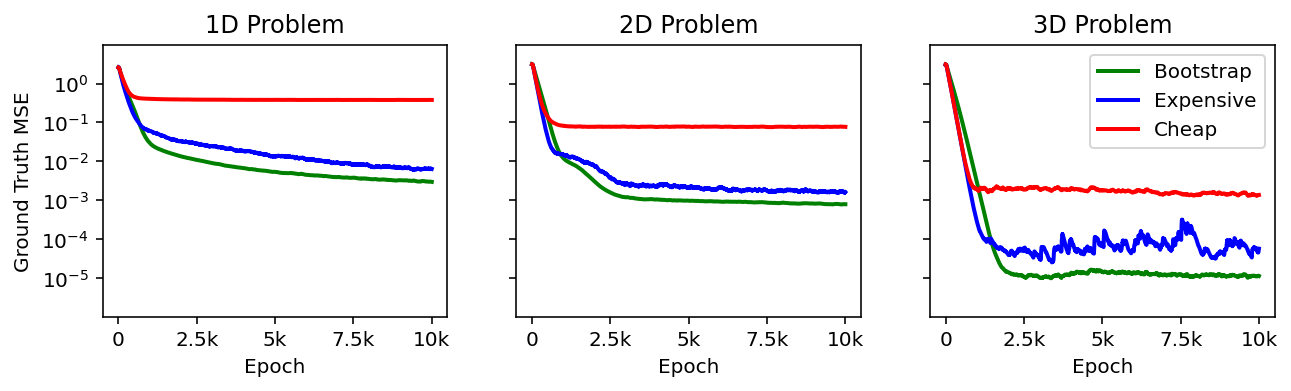

In [19]:
logroot = '07_smolluchowski'
bstrap_dirs = ['01_bstrap_*', '04_bstrap_*', '07_bstrap_*']
mselv_dirs = ['02_mselv_*', '05_mselv_*', '08_mselv_*']
msehv_dirs = ['03_msehv_*', '06_msehv_*', '09_msehv_*']

bstrap_dirs = [glob.glob(f'{logroot}/{x}')[0] for x in bstrap_dirs]
mselv_dirs = [glob.glob(f'{logroot}/{x}')[0] for x in mselv_dirs]
msehv_dirs = [glob.glob(f'{logroot}/{x}')[0] for x in msehv_dirs]
dim_list = [1, 2, 3]
share_y = True
n_rows, n_cols = 1, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*2.5), 
                         dpi=144, sharex=True, sharey=share_y)

for ax_idx, (d, ax, bstrap_dir, mselv_dir, msehv_dir) in enumerate(zip(dim_list, axes, 
    bstrap_dirs, mselv_dirs, msehv_dirs)):
    
    dfbstrap = pd.read_csv(f'{bstrap_dir}/progress.csv')
    dfmselv = pd.read_csv(f'{mselv_dir}/progress.csv')
    dfmsehv = pd.read_csv(f'{msehv_dir}/progress.csv')
    
    dfbstrap = dfbstrap.groupby(['epoch'], as_index=False).agg('mean').sort_values('epoch')
    dfmselv = dfmselv.groupby(['epoch'], as_index=False).agg('mean').sort_values('epoch')
    dfmsehv = dfmsehv.groupby(['epoch'], as_index=False).agg('mean').sort_values('epoch')
    
    x1, y1 = dfbstrap['epoch'].values, ema(dfbstrap['gt_mse'].values)
    x2, y2 = dfmselv['epoch'].values, ema(dfmselv['gt_mse'].values)
    x3, y3 = dfmsehv['epoch'].values, ema(dfmsehv['gt_mse'].values)
    
    ax.plot(x1, y1, lw=2, color='green', label='Bootstrap')
    ax.plot(x2, y2, lw=2, color='blue', label='Expensive')
    ax.plot(x3, y3, lw=2, color='red', label='Cheap')
    
    ax.set_xticks(np.linspace(0, 10_000, 5))
    engfmt = EngFormatter(sep='')
    ax.xaxis.set_major_formatter(engfmt)
    ax.set_xlabel(f'Epoch')

    ax.set_yscale('log', base=10)
    if share_y:
        ax.set_yticks([0.00001, 0.0001, 0.001, 0.01, 0.1, 1])
        ax.set_ylim(0.000001, 10)
    if ax_idx == 0:
        ax.set_ylabel(f'Ground Truth MSE')
    if ax_idx == 2:
        ax.legend()
    
    ax.set_title(f'{d}D Problem')